By: Justin Messinger

# Introduction

Icebergs have always posed a threat to ships navigating threw the ocean. In 1912, the Titanic sank as a result of colliding with an iceberg. More than 1500 people died as a result of this tragedy. Even with better technology, drifting icebergs continue to pose threats to ships and crew. While often aerial reconnaissance and shore based techniques are used to assess risks, these methods are not feasible in remote areas. Often, the only available information is satellite data.

In this competition, we need to develop an algorithm that can automatically classify whether a remotely sensed target is a ship or an iceberg. Better detection of icebergs will help drive down the costs of assessing risks in these remote areas, and may even lead to fewer accidents.

For this project, we will be using Keras with a Tensorflow backend to build a convolutional neural network (Chollet 2015). Keras has a lot of built-in features that have proved useful over the course of the project. For example, early stopping can easily be implemented with Keras. Keras also provides a generator to process images, which can randomly rotate, scale, and flip training images. Finally, Keras has pretrained models for many state of the art convolutional networks, including VGG16, which we will be using in this project.

The section of code below shows the imports used in the notebook.

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.keras.api.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import os.path
import seaborn as sns
from skimage import data, io, filters, feature
from IPython.display import SVG

# Note: Tensorflow contains API that allows us to call the Keras API directly.
from tensorflow.contrib.keras.api.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.contrib.keras.api.keras.models import Sequential, Model
from tensorflow.contrib.keras.api.keras.optimizers import Adam
from tensorflow.contrib.keras.api.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.contrib.keras.api.keras.preprocessing.image import ImageDataGenerator
import tensorflow.contrib.keras.api.keras.layers

Populating the interactive namespace from numpy and matplotlib


/home/justin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Global parameters for batch size and early stopping.

Below are some of the global variables used in the project. I'll just briefly go over the first 2.

BATCH_SIZE is the size of the input batch. For this project we are using a NVIDIA GeForce GTX 960m as the GPU. While this GPU is fairly low end compared to others used in machine learning applications, we observed a nearly 10x reduction in training time over a normal CPU. Unfortunately, the GPU only has 2 GB of memory, which limited the range we could make our batch size. We chose a batch size of 32 for this project.

There is also PATIENCE, which is used for early stopping. Early stopping is an alternative to regularization that can effectively control the variance of the model and reduce the amount of overfitting that takes place (Bishop 2006). PATIENCE controls how many epochs to wait to see if the validation loss improves. In this project, we chose a patience of 15, which means that the model will stop training if the last best validation score was more than 15 epochs ago.

In [2]:
# Global variables
BATCH_SIZE = 32
PATIENCE = 15

# Maximum number of epochs (early stopping with cause training to cease long before it reaches this).
NUMBER_OF_EPOCHS = 1000

# Weight file for loading models from a previous session.
FILE_PATH = "pseudo_labelling.model_weights.hdf5"

# Data exploration
Below we can see some of data in the test and training set. The data contains 2 bands of image data. The data is detected from measuring the backscatter of signals sent from the satellite (using a horizontally polarlized light source).

band_1 shows observations of horizontally polarized backscatter (HH) and band_2 shows observations of vertically polarized backscatter (HV). The magnitude of observations in both channels can depend on a number of factors, including an object's reflective properties and incidence angle.

We are also given incidence angle of the satellite in the inc_angle column. This is the angle at which the satellite was oriented to take the picture. One of the extensions we made to this project was to add incidence angle as a parameter in our model. This information can not be sent through the convolution and pooling layers of a standard convolutional neural net, so some changes will have to be made in the dense layers.

In [3]:
train = pd.read_json("data/processed/train.json")
test = pd.read_json("data/processed/test.json")

print("Train size: {}".format(len(train.index)))
print("Test size: {}".format(len(test.index)))

display(train.head())
display(test.head())

Train size: 1604
Test size: 8424


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


## Example images
Below is a function to plot example images with their incidence angle and their associated label (if part of the training set). We show 3 examples from both the training and test set.


Training images:

is_iceberg: True; incidence angle: 34.4878;


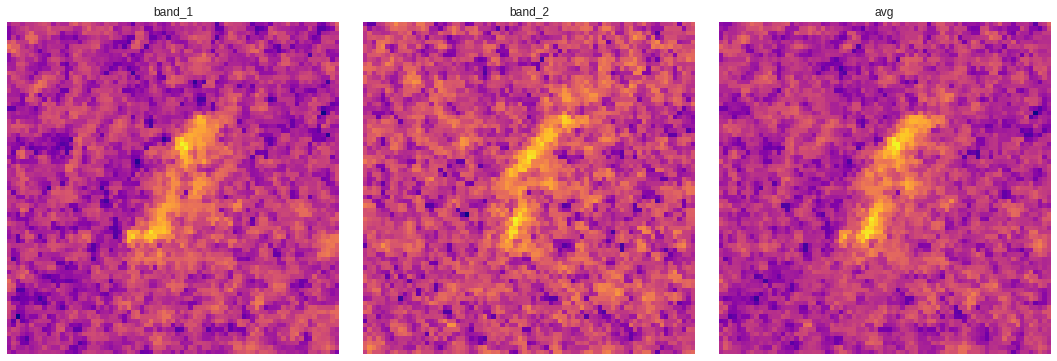




is_iceberg: False; incidence angle: 34.8702;


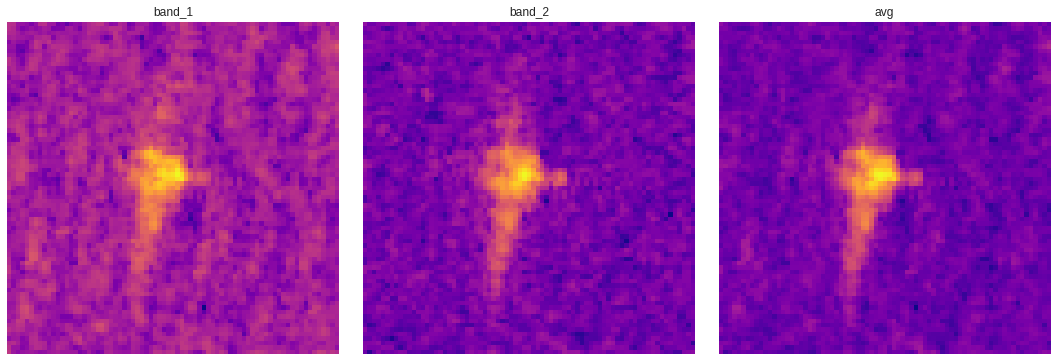




is_iceberg: True; incidence angle: 39.6316;


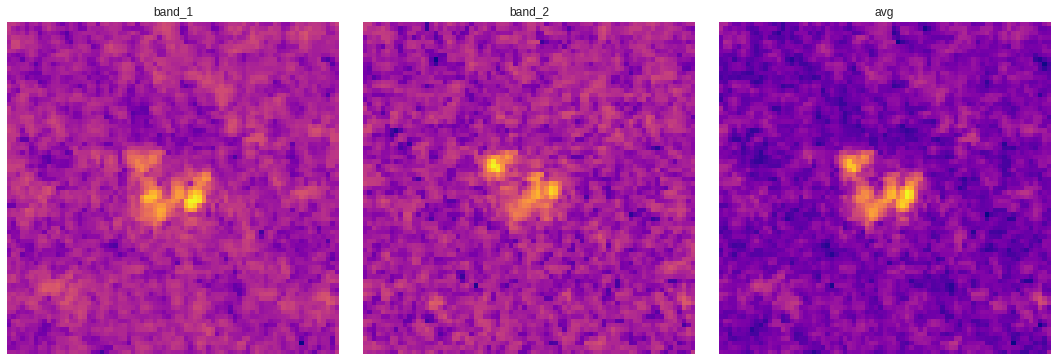





Test images:

incidence angle: 43.2371;


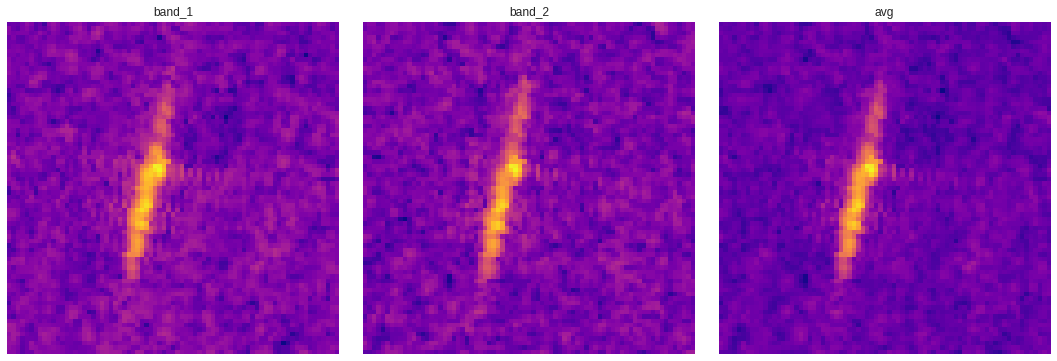




incidence angle: 46.98547521485566;


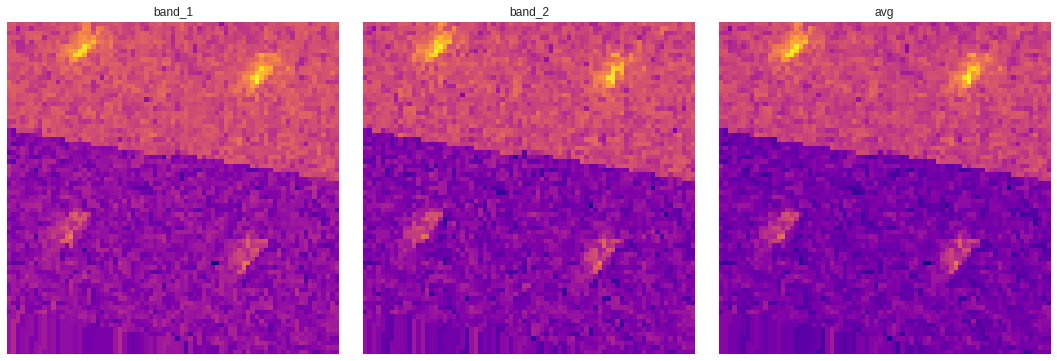




incidence angle: 39.34404970143928;


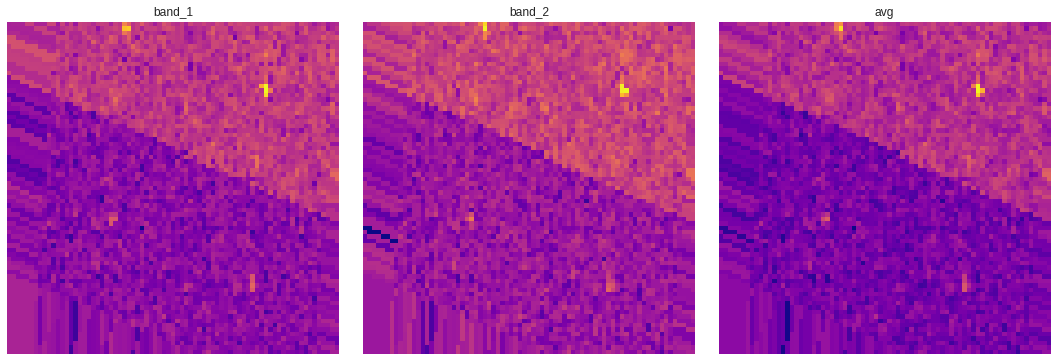

In [4]:
def display_example(example, data_type='train'):
    img1 = np.array(example["band_1"].as_matrix()[0]).reshape(75,75)
    img2 = np.array(example["band_2"].as_matrix()[0]).reshape(75,75)
    img3 = (img1 + img2) / 2
    
    angle = example['inc_angle'].iloc[0]
    
    plt.figure(figsize=(15,5))
    
    if(data_type=='train'):
        is_iceberg = int(example["is_iceberg"])
        
        # A value of 1 means the object is a iceberg.
        if(is_iceberg==1):
            is_iceberg = True
        else:
            is_iceberg = False
        
        print("is_iceberg: {}; incidence angle: {};".format(is_iceberg, angle))
    else:
        print("incidence angle: {};".format(angle))
    
    
    plt.subplot(1, 3, 1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img1, cmap=plt.get_cmap('plasma'))
    plt.title('band_1')
    
    plt.subplot(1, 3, 2)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img2, cmap=plt.get_cmap('plasma'))
    plt.title('band_2')
    
    plt.subplot(1, 3, 3)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img3, cmap=plt.get_cmap('plasma'))
    plt.title('avg')
    
    plt.tight_layout()
    plt.show()
    print('\n\n')


print("\nTraining images:\n")

display_example(train.sample(1, random_state=2))
display_example(train.sample(1, random_state=12345216))
display_example(train.sample(1, random_state=3465466))

print("\nTest images:\n")
display_example(test.sample(1, random_state=22348), data_type='test')
display_example(test.sample(1, random_state=346436), data_type='test')
display_example(test.sample(1, random_state=7473547), data_type='test')

Each example displays 3 images: band_1, band_2, and the average of the two bands. Higher values appear in yellow. As you can see, the measurements are quite noisy and for some images are very difficult to classify. Notice that some of the test set images has some odd looking artifacts. These are examples of machine generated images put into the test set. These images are put in to make hand labelling more difficult.

# Dealing with missing incidence angles
From looking at the examples, we notice that some examples contain missing values for the incidence angle. For the training data, there are 133 samples with missing incidence angles (out of 1644 total samples). The test data however contains no missing data.

Number of entries in training set with no incidence angle: 133


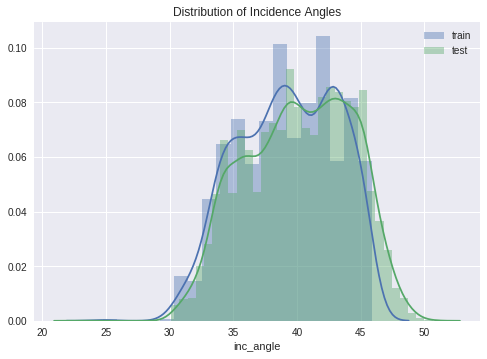

In [5]:
nulls_entries = train.loc[train['inc_angle'] == 'na']
num_nulls = nulls_entries['inc_angle'].value_counts()[0]
print("Number of entries in training set with no incidence angle: {}".format(num_nulls))

# Removing rows without an incidence angle since there are only 133 entries.
train = train[train.inc_angle != 'na']

# Make distribution plot of incidence angles
sns.distplot(train['inc_angle'], label='train')
sns.distplot(test['inc_angle'], label='test')
plt.title('Distribution of Incidence Angles')
plt.legend()
plt.show()

For most of the time working on the project, we set missing incident angles to the average value. However, we also tested dropping the samples with from the training data, and observed a decrease in the log loss. One reason removing the samples may have helped is because setting the incidence angles to the average may have changed the training distribution away from the test set distribution. Also by setting an arbitrary value for the incidence angle, we may have been making it harder for the model to learn how the incidence angle affects the classification.

# Extracting features

Before we showcase our model, let's briefly look at what features we extract. We will be using VGG16 as the base convolutional network. In order to use this prebuilt model, we must have exactly 3 image channels. Since the dataset we are studying only has 2 channels, we must come up with a way to use the 3rd channel.

One simple idea is to create a channel which uses the per pixel average of the HH and HV channels. This was found to be better than using an array of zeros, and has the advantage of the weights being roughly the same size as the other two channels.

In [6]:
def getImagesAndAngles(df):
    """
    Get the image data from the dataframe. The first two channels
    are band_1 and band_2 from the dataset, and the third channel is the
    average of band_1 and band_2
    
    Args:
        df: A dataframe of the iceberg data
    Returns:
        X: a 4D array of size [-1, 75, 75, 3]
    """
    #Get the band data
    band1 = df['band_1'].as_matrix()
    band2 = df['band_2'].as_matrix()
    
    #Create the channels, including an addition channel that takes the average of each band
    channel1 = np.concatenate(band1, axis=0).reshape((-1,75,75,1)).astype(np.float32)
    channel2 = np.concatenate(band2, axis=0).reshape((-1,75,75,1)).astype(np.float32)
    
    avg_channel = (channel1 + channel2) / 2
    
    imgs = np.concatenate((channel1, channel2, avg_channel), axis=-1)
    
    #Get the incidence angles (in radians)
    inc_angles = df['inc_angle'].as_matrix().astype(np.float32) * 2.0 * np.pi / 360.0
    
    return np.asarray([[imgs[i], inc_angles[i]] for i in range(len(imgs))])

# Our Model

As mentioned before, we are using VGG16 as our base convolutional network. VGG uses a series of small 3x3 convolution filters with a stride of 1, and the model was able to achieve state-of-the-art results in ImageNet (Simonyan and Zisserman 2014). The key idea of the paper is that 3x3 convolution layers can be stacked to mimic the behavior of larger receptive fields. For example, two 3x3 convolutional layers stacked has an effective receptive file of 5x5 (Simonyan and Zisserman 2014). Using 3x3 instead of larger sizes has the advantage of reducing the number of parameters. For example, a 7x7 convolution layer with C channels requires $7^2C=49C$ parameters. But using three 3x3 convolution layers instead requires only $3*3^2C=27C$ parameters.

Keras already has a built in model for VGG16. In fact, it also has the weights for imagenet. Even though this problem is very different from imagenet, we found that starting from the imagenet weights worked better than starting from random weights.

## Modifications from VGG16

Now our problem has some diffrences to ImageNet which will require changes. One difference, is that or image data has a shape of (75, 75, 2) instead of (224, 224, 3). As mentioned before, we add an extra channel so that our image data has a shape of (75, 75, 3).

Another consideration is that we have an extra parameter (incidence angle). Our original model didn't include this parameter, but in order to minimize our loss, the angle needs to be included. After the global max pooling layer (the final layer of the convolutional part of the network), we concatenate the output with the incidence angle.

The concatenation layer has an output of 513 nodes, which is quite different from the original VGG16 output (4096 nodes). This requires us to heavily modify the dense part of the network. We decided to add 2 dense layers of sizes 512 and 256. In these layers we preform dropout to add some regularization to the network. Finally, the last dense layer connects to a 1 node dense layer, where a sigmoid activation is used instead of rectified linear units (ReLU).

## Optimizer

We use Adam (Kingma and Ba 2014) as our optimizer. The advantage of Adam over other optimizers (such as stochastic gradient descent) is that it automatically performs simulated annealing, so manual step size lowering is not needed.

The code below shows the creation of the model used for the competition.

In [7]:
def getVGG16(learning_rate=1E-4, dropout_probability=0.2):
    VGG16_base = keras.applications.vgg16.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape=(75,75,3),
                                                classes=1, pooling=None)
    
    
    # Get the last layer of the cnn.
    layer = VGG16_base.get_layer("block5_pool").output
    
    # Flatten the layer
    layer = Flatten()(layer)
    
    # Create another input (the incidence angles) before the dense neural network.
    inc_angle_inputs = Input(shape=(1,), name='inc_angle')
    concat_layer = keras.layers.concatenate([layer, inc_angle_inputs])
    
    #Dense Layer l
    dense1 = Dense(512)(concat_layer)
    dense1 = Activation('relu')(dense1)
    dense1 = Dropout(dropout_probability)(dense1)
    
    #Dense Layer 2
    dense2 = Dense(128)(dense1)
    dense2 = Activation('relu')(dense2)
    dense2 = Dropout(dropout_probability)(dense2)
    
    output = Dense(1)(dense2)
    output = Activation('sigmoid')(output)
    
    model = Model(inputs=[VGG16_base.input, inc_angle_inputs], outputs=output)
    
    mypotim=keras.optimizers.Adam(learning_rate, decay=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = getVGG16(learning_rate=1e-4, dropout_probability=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 75, 75, 64)    1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 75, 75, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 37, 37, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

# Early Stopping
Below is the callbacks we use for our network. One of the callbacks we use is called EarlyStopping. This feature will stop training if evaluation results don't improve after a certain number of epochs. In our case, we stop training after 15 epochs when the loss doesn't improve. Early stopping acts as a form of regularization for our model. The second callback, ModelCheckpoint, will save the best weights for the model, which pairs quite well with early stopping.

In [8]:
def get_callbacks(filepath, patience=15):
    early_stopping = EarlyStopping('val_loss', patience=patience, mode="min")
    model_saving = ModelCheckpoint(filepath, save_best_only=True)
    return [early_stopping, model_saving]

## Data Augmentation
One simple way to increase the amount of data we have is to perform transformations to our image on each training batch. For example, we could flip or rotate an image and use that as input, effectively increasing our training size.

Keras has a built-in ImageDataGenerator class which can automatically perform these augmentations on each batch. We allow the generator to randomly flip images horizontally, randomly rotate images by up to 20 degrees, and randomly zoom the image. We could have also flipped vertically, but decided against it. This is because the angle of incidence (essentially a measure of the direction the satellite) may no longer be accurate if the angle is flipped vertically. We also use a smaller rotation range because of this.

Keras doesn't have a built-in way to generate batches with multiple inputs, so we must define our own generator. Below is the code used to create the generator. The function yields batches of input which we can use to train our model.

In [9]:
def create_generator(X1, X2, Y):
    """ Create a generator for our convolutional neural network. This returns a
    preprocessed batch of images and incidence angles."""
    datagen = ImageDataGenerator(horizontal_flip=True,
                                 vertical_flip=False,
                                 rotation_range=20,
                                 zoom_range=0.4)
    
    # Trick to generate X1, X2, and Y with flow.
    # NOTE: If shuffle is used, both iterators MUST have the same seed.
    SEED = np.random.randint(0,2147483647)
    genX1 = datagen.flow(X1, Y, batch_size=BATCH_SIZE, seed=SEED, shuffle=True)
    genX2 = datagen.flow(X1, X2, batch_size=BATCH_SIZE, seed=SEED, shuffle=True)
    
    while True:
        x_y_batch = genX1.next()
        x_angle_batch = genX2.next()
        
        img = x_y_batch[0]
        angle = x_angle_batch[1]
        y = x_y_batch[1]
        
        yield [img, angle], y

## Helper functions for training
Below are some functions to help with training and evalulating the results. `train_model` will use the input to train and evalulate our network. Notice that the function calls the `create_generator` and `get_callbacks` methods which were defined earlier. At the end of training, the function loads the best weights found, and evaluates the validation data.

`create_submission` will take a list of predictions and convert it into a csv file that can be submitted to the Kaggle competition.

Finally, `predict` will take the model and evalulate the probability that each image is an iceberg.

In [10]:
def train_model(X_train, y_train, X_valid, y_valid, model):
    
    # Extract the images and inc_angles
    X_train_imgs = np.asarray([x[0] for x in X_train])
    X_valid_imgs = np.asarray([x[0] for x in X_valid])
    X_train_angles = np.asarray([x[1] for x in X_train])
    X_valid_angles = np.asarray([x[1] for x in X_valid])
    
    # Get the batch generator and the callbacks
    generator = create_generator(X_train_imgs, X_train_angles, y_train)
    callbacks = get_callbacks(filepath=FILE_PATH, patience=PATIENCE)
    
    # Train the model
    model.fit_generator(generator,
                         steps_per_epoch=len(X_train) // BATCH_SIZE,
                         epochs=NUMBER_OF_EPOCHS,
                         verbose=1,
                         validation_data=([X_valid_imgs, X_valid_angles], y_valid),
                         callbacks=callbacks)
    
    # Load best weights
    model.load_weights(FILE_PATH)
    
    # Evaluate the model (with the best weights found).
    score = model.evaluate([X_valid_imgs, X_valid_angles], y_valid, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
def create_submission(probs, filename='out.csv'):
    submission = pd.DataFrame()
    submission['id']=test['id']
    submission['is_iceberg']=probs.reshape(probs.shape[0])
    submission.to_csv(filename, index=False)
    
def predict(model):
       
    X = getImagesAndAngles(test)
    
    imgs = np.asarray([x[0] for x in X])
    angles = np.asarray([x[1] for x in X])
    
    # Predict probabilites
    probs = model.predict([imgs, angles])
    
    print(probs)
        
    create_submission(probs)

# Pseudo-Labelling
Finally, as a way of improving our results, we use pseudo-labelling. Pseudo-labelling is a form of semi-supervised machine learning where you use labelled and unlabelled data to train a model. Essentially, we use our model to classify test data, but instead of stopping there, we now use the classified data as input to train our model further.

In this competition, there are 1604 labelled samples and 8424 unlabelled samples. The large amount of unlabelled data may suggest that this technique could be useful. One caveat is that competetion rules state that there are machine generated images in the test set. This is to act as a deterrent in hand-labelling data, however it may hinder the effectiveness of pseudo-labelling.

Below is a function which creates a new dataframe which will apply a model to classify and create new training data from the test set.

In [11]:
def pseudo_label(model):
    pseudo_train = test.sample(frac=0.1)
    X = getImagesAndAngles(pseudo_train)
    
    X_imgs = np.asarray([x[0] for x in X])
    X_angles = np.asarray([x[1] for x in X])
    
    y = model.predict([X_imgs, X_angles], verbose=1)
    
    # converts probabilites into a classification (0 or 1).
    targets = [int(round(a[0])) for a in y]
    
    # set
    pseudo_train['is_iceberg'] = y
    
    return pseudo_train

# Training and Results

Finally, we train our convolutional neural network. Our process consisted of the following:
1. Create the VGG16 network and initialize it to the imagenet weights (random weights were initialized for our designed dense layer). We would load the previous trained weights instead if continuing from a previous run.
2. Split the training set into 75% training data and 25% validation data.
3. Train the model until early stopping is invoked.
4. Use psuedo-labelling on a portion of the test data to create more training data. Train the model with this psuedo-labelled data (again until early stopping is invoked).
5. Repeat step 3 and 4, switching between training with the pseudo-labelled data and labelled data. Stop when satisified.

The code for this process is shown below. Only two iteration of the loop are shown as a demonstration. The output of the code is quite long (shows the loss every epoch), and may be worth skipping.

In [12]:
# seperate labelled data into train and validation sets
X = getImagesAndAngles(train)
y = train['is_iceberg']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=2356341, train_size=0.75, shuffle=True)


# Uncomment if using a previous model
#model.load_weights(FILE_PATH)

for i in range(2):
    # train
    train_model(X_train, y_train, X_valid, y_valid, model)

    # get psuedo-labelled data and train
    pseudo_train = pseudo_label(model)
    X_pseudo_train =  getImagesAndAngles(pseudo_train)
    y_pseudo_train = pseudo_train['is_iceberg']
    train_model(X_pseudo_train, y_pseudo_train, X_valid, y_valid, model)


# predict
model.load_weights(FILE_PATH)
predict(model)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/1000
34/34 [==============================] - 16s - loss: 0.6685 - acc: 0.6158 - val_loss: 0.4077 - val_acc: 0.8071
Epoch 2/1000
34/34 [==============================] - 14s - loss: 0.4635 - acc: 0.7873 - val_loss: 0.2516 - val_acc: 0.8777
Epoch 3/1000
34/34 [==============================] - 12s - loss: 0.4095 - acc: 0.8086 - val_loss: 0.3517 - val_acc: 0.8777
Epoch 4/1000
34/34 [==============================] - 13s - loss: 0.3437 - acc: 0.8509 - val_loss: 0.2063 - val_acc: 0.9076
Epoch 5/1000
34/34 [==============================] - 12s - loss: 0.3442 - acc: 0.8463 - val_loss: 0.2807 - val_acc: 0.8750
Epoch 6/1000
34/34 [==============================] - 12s - loss: 0.3188 - acc: 0.8647 - val_loss: 0.2533 - val_acc: 0.8832
Epoch 7/1000
34/34 [==============================] - 12s - loss: 0.2618 - acc: 0.8932 - val_loss: 0.2138 - val_acc: 0.9049
Epoch 8/1000
34/34 [==============================] - 12s - loss: 0.2805 - acc: 0.8941 - val_loss: 0.2538 - val_acc: 0.8913
Epoch 9/

34/34 [==============================] - 15s - loss: 0.1447 - acc: 0.9430 - val_loss: 0.1833 - val_acc: 0.9375
Epoch 18/1000
34/34 [==============================] - 13s - loss: 0.1280 - acc: 0.9492 - val_loss: 0.1888 - val_acc: 0.9321
Epoch 19/1000
34/34 [==============================] - 14s - loss: 0.1546 - acc: 0.9402 - val_loss: 0.2093 - val_acc: 0.9185
Epoch 20/1000
34/34 [==============================] - 15s - loss: 0.1290 - acc: 0.9429 - val_loss: 0.1910 - val_acc: 0.9293
Epoch 21/1000
34/34 [==============================] - 13s - loss: 0.1109 - acc: 0.9531 - val_loss: 0.2386 - val_acc: 0.9321
Epoch 22/1000
34/34 [==============================] - 15s - loss: 0.1281 - acc: 0.9512 - val_loss: 0.1621 - val_acc: 0.9429
Epoch 23/1000
34/34 [==============================] - 13s - loss: 0.1135 - acc: 0.9568 - val_loss: 0.2118 - val_acc: 0.9321
Epoch 24/1000
34/34 [==============================] - 13s - loss: 0.1035 - acc: 0.9577 - val_loss: 0.2080 - val_acc: 0.9321
Epoch 25/1000


# Results and Discussion

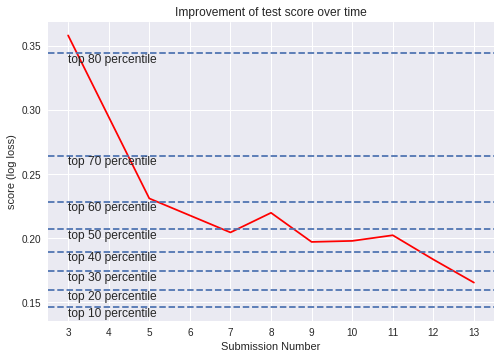

Best score: 0.1655


In [14]:
submission = [3, 5, 7, 8, 9,
              10, 11, 12, 13]
scores = [0.3582, 0.2311, 0.2046, 0.2199, 0.1972,
          0.1980, 0.2024, 0.1835, 0.1655]

best_score = min(scores)

#percentiles based on the 1604 teams on the leaderboard
percentiles = [("top 10 percentile", 0.1463),
               ("top 20 percentile", 0.1596),
               ("top 30 percentile", 0.1744),
               ("top 40 percentile", 0.1895),
               ("top 50 percentile", 0.2070),
               ("top 60 percentile", 0.2285),
               ("top 70 percentile", 0.2642),
               ("top 80 percentile", 0.3443)]

plt.plot(submission, scores, c='r')
for percentile in percentiles:
    string = percentile[0]
    score = percentile[1]
    plt.text(3,score-.007,string)
    plt.axhline(y=score, ls="--")
plt.title("Improvement of test score over time")
plt.ylabel("score (log loss)")
plt.xlabel("Submission Number")
plt.xticks(range(3,14))
plt.show()
print("Best score: {}".format(best_score))

A graph showing our improvement over submissions is shown above. Note that percentiles and placements are based on the leaderboard from December 11th and are subject to change. Also, we omit some of our earlier submissions for clarity. For example, our first submission assigned the opposite label to iceberg, giving us a log loss of 4.3.

Our first major improvement came from properly implementing VGG16 in submission 5 with random weights. Imagenet weights and the custom dense layer were introduced in submission 7. Then we spent a lot of time trying to fine tune the parameters. We were able to get down to 0.1972 loss, but struggled to get below that.

Probably the biggest breakthrough came from implementing pseudo-labelling. The first submission brought us down to 0.1835. The second submission cycled training between the labelled and unlabelled data, which brought us further down to 0.1655. These results suggest that pseudo-labelling was a great feature to incorporate.

# Conclusion

We were able to place well in the Statoil/C-CORE Iceberg Classifier Challenge. As of 8:45pm December 11, 2017, we are placed 527th out of 2235 teams, which puts us in the top 24% of all teams. We found that using the VGG16 base convolutional network, with our modification of the dense network to accept incidence angles, significantly improved our results. Furthermore, by using pseudo-labelling to boost the amount of training data, we were able improve the accuracy of our model. Future improvements to the model could be done by running a search over the vast amount of parameters, or by employing cross-validation.

# References
1. Chollet, F. (2015). Keras.
2. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.
3. Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
4. Kingma, D., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.